In [43]:
# Librerias tipicas para calculos y visualizaciones
import numpy as np
import matplotlib.pyplot as plt

# Para resolucion numerica
from scipy.optimize import least_squares

# Para matematica simbolica
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy import print_latex

plt.style.use('fivethirtyeight')
sp.interactive.init_printing(use_latex='mathjax')

# Enunciado

La reacción de síntesis catalítica de metanol puede ser representada mediante la siguiente ecuación 

\begin{equation*}
\text{CO(g)} + 2\text{H}_2\text{(g}) = \text{CH}_3\text{OH(g)}
\end{equation*}

Si se cuenta con una alimentación equimolar de los reactantes e igual a 5 moles a 200C. ¿Cuál será las fracciones molares si el sistema opera adiabáticamente a 10 bar y el catalizador permite que el sistema alcance el equilibrio sin que exista alguna otra reacción no deseada?

## Datos del problema

In [44]:
# Propiedades fisicoquimicas de los reactivos
# Calor y energia libre de Gibbs estandar de reaccion
# Coeficientes A y B para el calculo de las capacidades 
# calorificas a presion constante de los compuestos.

#                DHf(298)   DGf(298)  A     B x 10^2
#                 J/mol     J/mol
data = np.array([[-110530, -137160, 30.87, -1.285],
                 [0, 0, 27.14, 0.927],
                 [-200940, -162240, 21.15, 7.092]])

# Propiedades de operacion del reactor
TempInicial = 200 + 273.15       # Temperatura, K
PresionOp = 10                   # Presion, bar

# Datos de estado estandar para los calculos de equilibrio
Testandar = 298.15 
R = 8.314

# Datos de la reaccion
# Coeficientes estequimetricos y moles alimentados de los reactivos
#                      CO  H2 CH3OH
CoefMatrix = np.array([-1, -2, 1])  # negativo = reactivo, positivo = producto
molesAlime = np.array([5, 5, 0])

## Solucion

### Balance de moles

$$ n_i = n_{i0} + \nu_i\:\xi $$

In [45]:
xi = sp.symbols("xi", positive=True)

ni = molesAlime + CoefMatrix * xi
nTotal = np.sum(ni)
yi = ni / nTotal

In [46]:
print('    CO          H2        CH3OH')
display([yi[n] for n in np.arange(3)])

    CO          H2        CH3OH


⎡ 5 - ξ    5 - 2⋅ξ      ξ    ⎤
⎢────────, ────────, ────────⎥
⎣10 - 2⋅ξ  10 - 2⋅ξ  10 - 2⋅ξ⎦

El grado de avance de esta reaccion debe satisfacer la restriccion que los moles finales deben ser iguales o mayores que cero, lo cual ocurre cuando

In [47]:
sol = sp.solve([ni[n] >= 0 for n in np.arange(3)])
display(sol)

ξ ≤ 5/2

## Constante de equilibrio químico

### En funcion de la actividad de cada componente

Conociendo las expresiones de las composiciones que se alcanzarian en el equilibrio, se puede escribir la constante de equilibrio, K

$$ K(y) = \prod {a_i^{\nu_i}} = \prod {\frac{y_i\:P^{\nu_i}}{P^\circ}} $$

In [48]:
Ky = np.prod((yi * PresionOp)**CoefMatrix) 
display(Ky)

                2     
    ξ⋅(10 - 2⋅ξ)      
──────────────────────
             2        
100⋅(5 - 2⋅ξ) ⋅(5 - ξ)

### En funcion de la Energia Libre de Gibbs

Para conocer el valor del grado de avance se requiere conocer el valor de la constante de equilibrio, como una funcion de la temperatura de reaccion

$$ K(T) = \exp{\frac{-\Delta G^\circ(T)}{R\,T}} $$

Para lo cual es necesario resolver empleando el método de van't Hoff:

$$
\begin{align*}
&\ln K(T) = \ln K(T^\circ) + \frac{1}{R}\int_{T^\circ}^{T} \frac{\Delta H^\circ(t)}{t^2} \, dt\\
&\Delta H^\circ(T) = \Delta H^\circ(T^\circ) + \int_{T^\circ}^{T} {\Delta C_p^\circ(t) \, dt} \\
&\Delta C_p^\circ(t) = \sum{\nu_i\,C_{p,i}^\circ(T)} \equiv \sum{\nu_i\,A_i} + \sum{\nu_i\,B_i}\,T = \Delta A + \Delta B\,T
\end{align*}
$$

De esta manera, los calculos necesarios serian:

In [49]:
DA = np.sum(data[:, 2] * CoefMatrix)
DB = np.sum(data[:, 3] * 1e-2 * CoefMatrix)

DHT0 = np.sum(data[:, 0] * CoefMatrix)
DGT0 = np.sum(data[:, 1] * CoefMatrix)

KT0 = np.exp(-DGT0/R/Testandar)

In [50]:
print('El calor de reacción a 298.15 K es igual a {:.1f} J/mol'.format(DHT0))
print('El DG de reaccion a 298.15 K es igual a {:.1f} J/mol'.format(DGT0))
print('La constante de equilibrio químico a 298.15 K es igual a {:.3e}'.format(KT0))

El calor de reacción a 298.15 K es igual a -90410.0 J/mol
El DG de reaccion a 298.15 K es igual a -25080.0 J/mol
La constante de equilibrio químico a 298.15 K es igual a 2.478e+04


La expresión se Van't Hoff es una función que depende la temperatura, por lo cual se necesita una función de T

In [51]:
# Se definen dos variables para la expresion de van't Hoff
# t: variable de integracion
# T: variable que indica como cambia la temperatura dentro del reactor
t, T = sp.symbols("t, T", positive=True)

Expresiones para evaluar las energias a cualquier temperatura T, empleando el modulo _integrate_ de _Sympy_ 

In [52]:
# Funcion para el calor estandar de reaccion en funcion de T
DHt = DHT0 + sp.integrate(DA + DB * t, (t, 298.15, T))

# Expresion para constante de equilibrio en funcion de T
lnKe = np.log(KT0) + 1/R * (sp.integrate(DHt / (T**2), (T, 298.15, T)))

Ke = sp.exp(lnKe)

display(Ke)

                                                             8928.03211147913
                                     0.00392290113062305⋅T + ────────────────
                  -7.69785903295646                                 T        
8494102314.01275⋅T                 ⋅ℯ                                        

## Sistema de ecuaciones

El sistema de ecuaciones simbólicas son:

$$
\begin{aligned}
f_1(T,\xi) &= \frac{K_y(\xi)}{K_e(T)} - 1 \\
f_2(T,\xi) &= \sum{n_{e,i} \, \int_{T_e}^{T_{out}} C_{p_i}(t)\: dt} + \xi \: \Delta H^\circ (T)
\end{aligned}
$$

Con la restriccion que $ 0 \leq \xi \leq 2.5$ 

In [53]:
# Igualdad de las expresiones para la constante de equilibrio
F1 = sp.log(Ky) - lnKe

# Balance de energia
F2 = np.sum([molesAlime[n] * sp.integrate(data[n, 2] +  data[n, 3] * 1e-2 * t, (t, TempInicial, T)) 
             for n in np.arange(3)]) + xi * DHt

F3 = sp.expand(F2)
F4 = sp.collect(F3, T)
display(F4)

 2                                                                            
T ⋅(0.032615⋅ξ - 0.00895) + T⋅(290.05 - 64.0⋅ξ) - 74227.6589748375⋅ξ - 135233.

         
512743625

In [54]:
f1 = lambdify((T, xi), F1, "numpy")
f2 = lambdify((T, xi), F2, "numpy")

In [55]:
def problema(z, *args):
    """ Resuelve el grado avance y temperatura de operacion
    de un reactor que opera de forma adiabatica.
    
    Input: z: es un vector donde se encuentran las variables
           independientes: temperatura y grado de avance
           args: son las funciones que seran resueltas
           En este caso, args[0] es la funcion de igualdad de 
           constante de equilibrio mientras que args[1] es
           el balance de energia del reactor
    Output: funciones a ser resueltas por el resolvedor
    """
    temperatura, grado_avance = z
    ecuacion_1, ecuacion_2 = args
    
    fun1 = ecuacion_1(temperatura, grado_avance)
    fun2 = ecuacion_2(temperatura, grado_avance)
    return [fun1, fun2]

In [61]:
temperatura_minima = 300
temperatura_maxima = 800

grado_avance_minimo = 1e-8
grado_avance_maximo = 2.5 - 1e-8

x0 = (400, 0.01)
bnds = ((temperatura_minima, grado_avance_minimo), 
        (temperatura_maxima, grado_avance_maximo))
solucion = least_squares(problema, x0, 
                   args=(f1, f2), bounds=bnds)

In [62]:
# Verifica la solucion
solucion

 active_mask: array([0, 0])
        cost: 4.235165304251353e-22
         fun: array([-1.06581410e-14, -2.91038305e-11])
        grad: array([-8.02505207e-09,  2.88158337e-06])
         jac: array([[ 4.22632745e-02,  6.75680161e+00],
       [ 2.75738674e+02, -9.90104531e+04]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 82
        njev: 73
  optimality: 2.160118143107758e-06
      status: 3
     success: True
           x: array([5.30828146e+02, 1.63732946e-01])

In [63]:
print(("La temperatura de equilibrio es {:.2f} K, \n"
       "mientras que el grado de avance es igual a {:.4f}".
       format(solucion.x[0], solucion.x[1])))

La temperatura de equilibrio es 530.83 K, 
mientras que el grado de avance es igual a 0.1637


Las composiciones en el equilibrio seran:

In [59]:
print("CO(g): {:9.4f}".format(yi[0].subs(xi, solucion.x[1])))
print("H2(g): {:9.4f}".format(yi[1].subs(xi, solucion.x[1])))
print("CH3OH(g): {:6.4f}".format(yi[2].subs(xi, solucion.x[1])))

CO(g):    0.5000
H2(g):    0.4831
CH3OH(g): 0.0169


## Estimacion grafica

En caso que se desea una solución estimada, se podría construir un gráfico de las funciones (constante de equilibrio y balance de energía) de la siguiente manera:

1. Se supone la temperatura de reacción (es mucho mas simple)
2. Se calcula el grado de avance mediante la funcion f1 para el valor T supuesto.
3. Con el valor de grado de avance calculado y T supuesta se determina el calor del reactor
4. Se grafican ambas curvas. 

La solución estimada será cuando el balance de energía sea igual a cero.

In [64]:
def funSup(ts, *args):
    """Resuelve la ecuacion de la constante de equilibrio

    Args:
        ts (float): temperatura supuesta del reactor, K
        low (float): valor minimo del grado de avance
        high (float): valor maximo del grado de avance

    Returns:
        solucion numerica de la ecuacion
    """
    funcion_ky, low, high = args
    funcion_ke = lambda x: funcion_ky(ts, x)
    return least_squares(funcion_ke, 0.01, bounds=((low, high))).x
 

In [69]:
Tsup = np.linspace(500, 700, 50)

Xi_calc = []
Q_calc = []
argumentos = (f1, grado_avance_minimo, grado_avance_maximo)               
for n in np.arange(len(Tsup)):
    grado_avance_calculado = funSup(Tsup[n], *argumentos)
    
    Xi_calc.append(grado_avance_calculado)
    Q_calc.append(f2(Tsup[n], grado_avance_calculado))

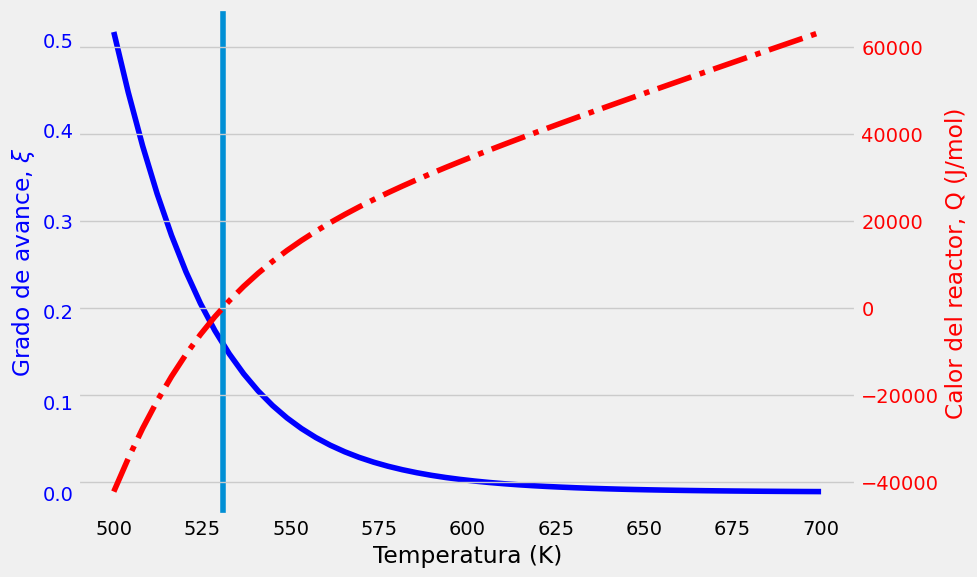

In [70]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.grid(False)
ax1.plot(Tsup, Xi_calc, 'b-')
ax1.set_xlabel('Temperatura (K)')
ax1.set_ylabel('Grado de avance, ' r'$\xi$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(Tsup, Q_calc, 'r-.')
ax2.set_ylabel('Calor del reactor, Q (J/mol)', color='r')
ax2.tick_params('y', colors='r')

ax1.axvline(x=solucion.x[0])

fig.tight_layout()